In [1]:
from src.hartree_fock_library import HartreeFock,HartreeFockVariational
from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict,List
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
#from src.qml_models import AdaptVQEFermiHubbard
import matplotlib.pyplot as plt
#from adapt_vqe_old import AdaptVQEFermiHubbard

In [2]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name='data/cki')

SPS=SingleParticleState(file_name='data/cki')




print(twobody_matrix)

#%% initialize the FH Hamiltonian

FHHamiltonian=FermiHubbardHamiltonian(size_a=energies.shape[0]//2,size_b=energies.shape[0]//2,nparticles_a=2,nparticles_b=2)

FHHamiltonian.get_external_potential(external_potential=energies)
FHHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
FHHamiltonian.get_hamiltonian()

egs,psi0=FHHamiltonian.get_spectrum(n_states=1)

print(egs)








   0 1   103 103 103 103    0    3     

     0.0000   -3.1398     0.0000   -6.6779

   -2.7352     0.0000    -0.6490     0.0000

   0 1   103 103 103 101    1    2

    4.0238     0.0000

     0.0000   -2.2055

   0 1   103 103 101 101    0    1

     0.0000    1.0893

   -5.3229     0.0000

   0 1   103 101 103 101    1    2

   -6.5365   -4.2246

     0.8630   -1.1408

   0 1   103 101 101 101    1    1

    1.3920

     0.0000

   0 1   101 101 101 101    0    1

     0.0000   -4.2568

     0.3397     0.0000

-4.0238
0.0
0.0
2.2055
6.5365
0.863
-4.2246
1.1408
[1.63, 2.27]


100%|██████████| 12/12 [00:02<00:00,  4.19it/s]


[1.63, 2.27]
{(0, 1, 0, 1): -0.6490000000000002, (0, 1, 1, 0): 0.6490000000000002, (1, 0, 0, 1): 0.6490000000000002, (1, 0, 1, 0): -0.6490000000000002, (0, 1, 0, 4): 2.2055000000000007, (0, 1, 4, 0): -2.2055000000000007, (1, 0, 0, 4): -2.2055000000000007, (1, 0, 4, 0): 2.2055000000000007, (0, 2, 0, 2): -0.6490000000000002, (0, 2, 2, 0): 0.6490000000000002, (2, 0, 0, 2): 0.6490000000000002, (2, 0, 2, 0): -0.6490000000000002, (0, 2, 0, 5): 1.1027500000000003, (0, 2, 5, 0): -1.1027500000000003, (2, 0, 0, 5): -1.1027500000000003, (2, 0, 5, 0): 1.1027500000000003, (0, 2, 1, 4): 1.91001902804658, (0, 2, 4, 1): -1.91001902804658, (2, 0, 1, 4): -1.91001902804658, (2, 0, 4, 1): 1.91001902804658, (0, 3, 0, 3): -1.6921, (0, 3, 3, 0): 1.6921, (3, 0, 0, 3): 1.6921, (3, 0, 3, 0): -1.6921, (0, 3, 1, 2): 1.0430999999999995, (0, 3, 2, 1): -1.0430999999999995, (3, 0, 1, 2): -1.0430999999999995, (3, 0, 2, 1): 1.0430999999999995, (0, 3, 1, 5): 1.1027500000000001, (0, 3, 5, 1): -1.1027500000000001, (3, 0, 

In [3]:
# %% Hartree fock initialization

HFclass = HartreeFock(size=energies.shape[0]//2, nspecies=2)

HFclass.get_hamiltonian(twobody_interaction=twobody_matrix, external_potential=energies)

de,history_herm,ortho_history=HFclass.selfconsistent_computation(eta=1,epochs=50)

de=0.000000000000000: 100%|██████████| 50/50 [00:00<00:00, 505.48it/s]


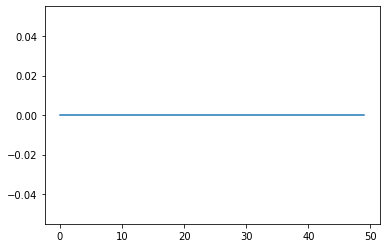

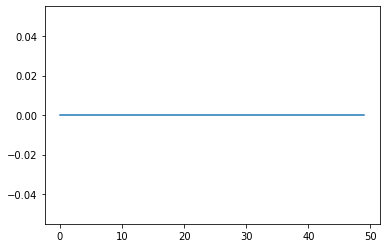

-11.863525000000003


In [4]:
plt.plot(history_herm)
plt.show()

plt.plot(ortho_history)
plt.show()

energy=HFclass.compute_energy()

print(energy)

In [5]:
psi_hf = HFclass.create_hf_psi(FHHamiltonian.basis, nparticles=4)
print(psi_hf.conjugate().transpose() @ FHHamiltonian.hamiltonian @ psi_hf)

-8.898985000000009


1.0
0.0


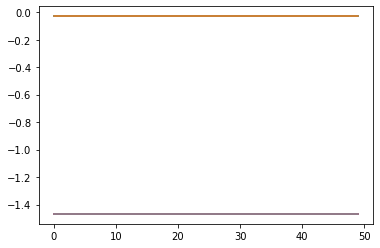

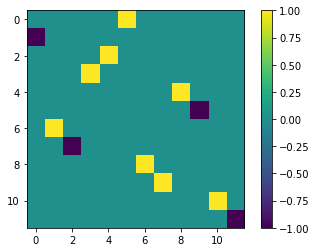

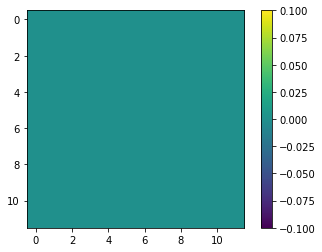

0 0
1.0
0 1
0.0
0 2
0.0
0 3
0.0
0 4
0.0
0 5
0.0
1 1
1.0
1 2
0.0
1 3
0.0
1 4
0.0
1 5
0.0
2 2
1.0
2 3
0.0
2 4
0.0
2 5
0.0
3 3
1.0
3 4
0.0
3 5
0.0
4 4
1.0
4 5
0.0
5 5
1.0


In [6]:
print(np.linalg.norm(HFclass.weights[:, 0]))
print(np.sum(HFclass.weights[0, :].conj() * HFclass.weights[:, 1]))

plt.plot(de)
# plt.semilogy()
# plt.ylim([0,0.001])
plt.show()

plt.imshow(np.real(HFclass.weights))
plt.colorbar()
plt.show()
plt.imshow(np.imag(HFclass.weights))
plt.colorbar()
plt.show()

for i in range(energies.shape[0]//2):
    for j in range(i,energies.shape[0]//2):
        print(i,j)
        print(np.dot(HFclass.weights[:,i],b=(HFclass.weights[:,j])))

In [7]:
operator_pool:Dict={}

operator_pool=FHHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation],nbody='two')

operator_pool=FHHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation],nbody='one')
#%%
print(operator_pool.keys())

# %%
random=False

# AdVQE=AdaptVQEFermiHubbard()

# #initialize psi0

# #idxs=np.array([0,10])




# AdVQE.set_system(hamiltonian=FHHamiltonian.hamiltonian,psi0=psi_hf,operator_pool=operator_pool)

# AdVQE.set_hyperparameters(learning_rate=0.1,tolerance=10**-6)

# AdVQE.optimization()


model=AdaptVQEFermiHubbard()

model.set_hamiltonian(FHHamiltonian.hamiltonian)
model.set_reference_psi(psi_hf)
model.set_operators_pool(operator_pool=operator_pool,random=random)

#%%

fit=Fit(method='L-BFGS-B',tolerance_opt=10**-6)

fit.configuration_checkpoint=configuration
fit.init_model(model)
history_energy,history_grad=fit.run()

[0, 0, 0, 0]
-3.0 -3.0 1.0 1.0
condition= True
condition= True
condition again= True
[0, 0, 0, 0]
[0, 0, 0, 1]
-2.0 -3.0 1.0 1.0
condition= False
condition= False
[0, 0, 0, 2]
-1.0 -3.0 1.0 1.0
condition= False
condition= False
[0, 0, 0, 3]
0.0 -3.0 1.0 1.0
condition= False
condition= False
[0, 0, 0, 4]
-2.0 -3.0 1.0 1.0
condition= False
condition= False
[0, 0, 0, 5]
-1.0 -3.0 1.0 1.0
condition= False
condition= False
[0, 0, 0, 6]
-3.0 -3.0 0.0 1.0
condition= False
condition= False
[0, 0, 0, 7]
-2.0 -3.0 0.0 1.0
condition= False
condition= False
[0, 0, 0, 8]
-1.0 -3.0 0.0 1.0
condition= False
condition= False
[0, 0, 0, 9]
0.0 -3.0 0.0 1.0
condition= False
condition= False
[0, 0, 0, 10]
-2.0 -3.0 0.0 1.0
condition= False
condition= False
[0, 0, 0, 11]
-1.0 -3.0 0.0 1.0
condition= False
condition= False
[0, 0, 1, 1]
-1.0 -3.0 1.0 1.0
condition= False
condition= False
[0, 0, 1, 2]
0.0 -3.0 1.0 1.0
condition= False
condition= False
[0, 0, 1, 3]
1.0 -3.0 1.0 1.0
condition= False
condition= 

KeyboardInterrupt: 

In [ ]:
rel_error=[np.abs((e_min-egs)/egs) for e_min in history_hf]

plt.figure(figsize=(10,10))
plt.plot(rel_error,linewidth=5)
plt.xlabel('epochs',fontsize=40)
plt.semilogy()
plt.ylabel(r'$\Delta_r e$',fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.show()

In [ ]:
mutual_info=FHHamiltonian.mutual_info(psi_hf)


plt.imshow(mutual_info)
plt.colorbar()

plt.show()

mutual_info=FHHamiltonian.mutual_info(psi0)


plt.imshow(mutual_info)
plt.colorbar()

plt.show()

In [ ]:
# FIDELITY

print(psi_hf.conjugate().dot(psi0)**2)

In [7]:

operator_pool:Dict={}

operator_pool=FHHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation],nbody='two')

#operator_pool=FHHamiltonian.set_operator_pool(operator_pool=operator_pool,n_new_operators=300,conditions=[spinconservation.spin_conservation],nbody='one')
#%%
print('number of operators=',len(list(operator_pool.keys())))

# %%
random=False

model=AdaptVQEFermiHubbard()

model.set_hamiltonian(FHHamiltonian.hamiltonian)
model.set_reference_psi(psi_hf)
model.set_operators_pool(operator_pool=operator_pool,random=random)

#%%

fit=Fit(method='BFGS',tolerance_opt=10**-7,e_ref=egs)

fit.configuration_checkpoint=configuration
fit.init_model(model)

#%%
history,grad_history=fit.run(epochs=100)
# # %%
print(model.operator_action_info)
print(model.energy-egs/egs)

 it does not conserve the number of Particles, Hombre! 

 it does not conserve the number of Particles, Hombre! 



TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [ ]:
spinconservation=SpinConservation(size=size_a//2)
operator_pool:Dict={}

operator_pool=FHHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[spinconservation.spin_conservation],nbody='two')

AdVQE=AdaptVQEFermiHubbard()






AdVQE.set_system(hamiltonian=FHHamiltonian.hamiltonian,psi0=psi_target[:,0],operator_pool=operator_pool)

AdVQE.set_hyperparameters(learning_rate=0.1,tolerance=10**-6)

AdVQE.optimization()

In [ ]:
rel_error=[np.abs((e_min-egs)/egs) for e_min in history]

plt.figure(figsize=(10,10))
plt.plot(rel_error,linewidth=5)
plt.xlabel('epochs',fontsize=40)
plt.semilogy()
plt.ylabel(r'$\Delta_r e$',fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.show()


plt.figure(figsize=(10,10))
plt.plot(grad_history,linewidth=5)
plt.xlabel('epochs',fontsize=40)
plt.semilogy()
plt.ylabel(r'grad',fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.show()
